In [1]:
%matplotlib inline
import tensorflow as tf 
!pip install tensorflowjs
import tensorflowjs as tfjs
!pip install mitdeeplearning
import mitdeeplearning as mdl
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

     |████████████████████████████████| 77 kB 661 kB/s            
     |████████████████████████████████| 14.8 MB 1.2 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77056 sha256=cf358a2d75dcab40177fa733e1854cc9aa29be6a441b34b1377849a7b324d9e6
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: wrapt
    Fou

In [2]:
!ls

__notebook__.ipynb


In [3]:
songs = mdl.lab1.load_training_data()
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [4]:
songs_joined = "\n\n".join(songs) 

vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [5]:
  
char2idx = {u:i for i, u in enumerate(vocab)}


idx2char = np.array(vocab)

In [6]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [7]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

In [8]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [9]:
def get_batch(vectorized_songs, seq_length, batch_size):
  
  n = vectorized_songs.shape[0] - 1
  
  idx = np.random.choice(n-seq_length, batch_size)

  
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  

  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [10]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=2)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: [ 2  0  0 49 22] (array(['!', '\n', '\n', 'X', ':'], dtype='<U1'))
  expected output: [ 0  0 49 22 19] (array(['\n', '\n', 'X', ':', '7'], dtype='<U1'))
Step   1
  input: [21  0 45 22 33] (array(['9', '\n', 'T', ':', 'H'], dtype='<U1'))
  expected output: [ 0 45 22 33 56] (array(['\n', 'T', ':', 'H', 'a'], dtype='<U1'))


In [11]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [12]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    LSTM(rnn_units), 
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

2022-04-16 07:26:11.080347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 07:26:11.181883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 07:26:11.183259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 07:26:11.185706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
model.summary()
tf.keras.utils.plot_model(model);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [14]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

2022-04-16 07:26:16.337319: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [15]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([39, 70, 35, 61, 43, 80, 60,  4, 66, 64, 82, 23, 79, 72,  1, 37, 48,
       32, 57, 18, 12, 44, 64, 37, 61, 15, 49, 63, 67, 58, 36, 36, 66, 63,
       63, 82, 40, 49, 17, 63, 11, 80, 64, 32, 69, 74, 27, 52, 61, 82, 57,
       36, 68, 65,  1, 47, 71, 58,  5, 64,  4, 54, 61, 70, 55,  4, 38, 82,
       60,  6, 10, 74, 40, 81, 49, 15, 60, 33, 42, 82, 76, 33, 57, 15, 21,
       34, 80, 54,  4, 63, 33, 11, 41, 59, 45, 36, 19, 75, 73, 73])

In [16]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'len Road to Carrick\nZ: id:dc-reel-115\nM:C\nL:1/8\nK:D Mixolydian\nzAG|FDD2 FDGE|FDFG ABGA|FDD2 FDGF|Edc'

Next Char Predictions: 
 "NoJfRye#ki|<xq LWGb60SiLf3XhlcKKkhh|OX5h/yiGnsB[f|bKmj Vpc'i#^fo_#M|e(.sOzX3eHQ|uHb39Iy^#hH/PdTK7trr"


In [17]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  
  return loss

example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.420583


In [18]:
num_training_iterations = 2000 
batch_size = 4  
seq_length = 100 
learning_rate = 5e-3  

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024 

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")



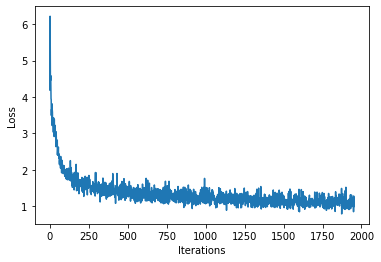

100%|██████████| 2000/2000 [00:52<00:00, 38.34it/s]


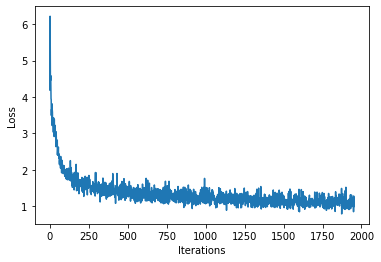

In [19]:
### Optimizer and training operation ###

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 
  with tf.GradientTape() as tape:
    y_hat = model(x) 
    
    loss = compute_loss(y, y_hat)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

############
# training!#
############

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for iter in tqdm(range(num_training_iterations)):

  
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  
  history.append(loss.numpy().mean())
  plotter.plot(history)

 
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)

model.save_weights(checkpoint_prefix)

In [20]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "./m.json")

/opt/conda/lib/python3.7/site-packages/tensorflowjs/write_weights.py:262: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


In [21]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) 
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()
model.save("m.hdf5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [22]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  input_eval = [char2idx[s] for s in start_string] 
  input_eval = tf.expand_dims(input_eval, 0)

 
  text_generated = []

  
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      
      predictions = model(input_eval)
      
      predictions = tf.squeeze(predictions, 0)
      
    
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])  
      
  return (start_string + ''.join(text_generated))

In [23]:
generated_text = generate_text(model, start_string="G", generation_length=3000)

100%|██████████| 3000/3000 [00:20<00:00, 144.01it/s]


In [24]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
    print(song)
    print()

Found 14 songs in text
Gg f2e|fed cAG|!
G Bd|e>f g2|eg g>a|g>g ab|af ed|ef ef|!
g2 a/g/f/e/d/|GB G>A BB|G4 cd|ef eg|!
fc AB/A/|G>B BA|BA Ae/e/|dB A/B/A/|BA AB/|ce gage|dfdB AGFG|[1 G ABc|d2e fag fde|!
GBd gdB|AGA BGG|ABd gdB|AGF G2:|!

X:62
T:Lack Street
Z: id:dc-reel-373
M:C
L:1/8
K:D Mixolydian
e|faa a2b|a^ga aa^g|aga ged|cAG FGD|!
ABA fAA|gfg fed|cdB GAB|Ad^c def|!
gfg age|dBAB GBdB|ABAG EFGA|BddB AEE2|]!

X:220
T:Maids of Street
Z: id:dc-reel-132
M:C
L:1/8
K:G Major
AB|ABBG AGEG|ABAG EFGA|BcBA GED2|ABAG FDA|]!

X:7
T:Paddy Damblor's Peeder
Z: id:dc-setdance-19
M:6/8
L:1/8
K:A Mixolydian
gfg ege|dBG GEB|AGA B2|!
AB A2|AB d>e|fe de|gf edBA BGAF|!
Aceg fedf edBA|BdGA Bdgd|efge BBBd|cdB BA:|!

X:219
T:Langst Holey
Z: id:dc-jig-187
M:D:|[2 G2dG BGG2|]!
B|dBAB ABdB|AdBd Adfd|eaab aged|cdef g4|
M:4/4
Bc|BdB|def gga|bab at
Z: id:dc-jig-123
M:6/8
L:1/8
K:E Minor
D2B,2 G,2A,2|B,c,G,G,B,A,A,G,A, DB,F,D|dcde faec|cBAF GABc|!
d2ed ecA2AF|GFGB cdcB|AGFE DEF2|CGAG ABcA|B2dB FAA:|!
f|g2A2 A2d2|cAA